In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.systems as cfs
import claude.claudeflow.helper as cfh
import claude.claudeflow.models.SSFstatic as ssf

In [3]:
# Tx
batch_size = 2
M = 16
frequencyShift = True
runs = 5

param = cfs.defaultParameters(precision='double')
param.Fs = param.sps * param.Rs
print(param)

nPol:	2
sps:	16
nSamples:	1024
rollOff:	0.05
filterSpan:	128
optimizeP:	False
PdBm:	1
Rs:	32000000000.0
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>
Fs:	512000000000.0



In [4]:
ssfParam = ssf.defaultParameters(precision='double')
ssfParam.gamma = 0 # easy debugging
ssfParam.Fs = param.Fs
ssfParam.N = param.sps * param.nSamples
ssfParam.noiseEnabled = True
ssfParam.noiseFigure = 5
ssfParam.nSpans = 10
print(ssfParam)

Fs:	512000000000.0
N:	16384
nSteps:	1
stepSize:	100
ampScheme:	EDFA
noiseEnabled:	True
manakovEnabled:	True
dispersionCompensationEnabled:	False
checkpointInverval:	2
nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	20.999953937404488
gamma:	0
nSpans:	10
spanLength:	100
noiseFigure:	5
intType:	<dtype: 'int32'>
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>
stepSizeTemplate:	[100.]



In [5]:
# Constants
c     = 299792458

constellation = tx.qammod(M)
print('const mean power: ', np.mean(np.abs(constellation)**2))
print('const.shape: ', constellation.shape)

const mean power:  1.0
const.shape:  (1, 16)


In [6]:
def run_model(param, ssfParam):
    tf.reset_default_graph()

    beta2 = tf.constant( ssfParam.D * 1e-6 * ( c / ssfParam.Fc )**2 / ( 2 * np.pi * c ), param.realType )
    dz = tf.constant( ssfParam.spanLength * 1e3 * ssfParam.nSpans, param.realType )

    nDims = 4 # Dimension of X
    X = tf.placeholder(tf.float32, shape=(None, param.nChannels, param.nPol, param.nSamples, M))
    constellation_tf = tf.constant(constellation, param.complexType)

    txSymbols = cfh.QAMencoder(X, constellation_tf, realOutput=False)

    signal = cfs.wdmTransmitter(txSymbols, param, frequencyShift=frequencyShift)

    ssfParam.stepSize = tf.placeholder(param.realType, shape=(ssfParam.nSpans, ssfParam.nSteps))
    signal_out = ssf.model(ssfParam, signal)

    signal_disp = cfh.dispersion_compensation(signal_out, beta2, dz, ssfParam.N, ssfParam.Fs)

    rxSymbols_out = cfs.wdmReceiver(signal_disp, param, frequencyShift=frequencyShift)

    # rxSymbols_out = rxSymbols_out * tf.exp( 1j * 0.4 ) # fake static phasenoise

    rxSymbols = cfh.staticPhaseRotationCompensation(rxSymbols_out)
    rxSymbols = cfh.testPhases(txSymbols, rxSymbols, constellation_tf, nDims, M, nTestPhases=4)

    tile_multiples = [1] * (nDims+1)
    tile_multiples[-1] = M

    # error counting
    rxSymbols_tiled = tf.tile( tf.expand_dims( rxSymbols, -1 ), tile_multiples )
    rxIdx = tf.argmin( tf.abs( rxSymbols_tiled - constellation_tf ), axis=-1 )

    txSymbols_tiled = tf.tile( tf.expand_dims( txSymbols, -1 ), tile_multiples )
    txIdx = tf.argmin( tf.abs( txSymbols_tiled - constellation_tf ), axis=-1 )

    errors = tf.reduce_sum( tf.cast( tf.not_equal( txIdx, rxIdx ), tf.int32 ), [0, 2, 3] )
    errorrate = tf.reduce_mean( tf.cast( tf.not_equal( txIdx, rxIdx ), tf.float32 ), [0, 2, 3] )

    # effSNR
    estNoisePower = tf.reduce_mean( tf.square( tf.abs( txSymbols - rxSymbols ) ), [0, 2, 3] )
    signalPower = tf.constant( 1 / param.nPol, param.realType)
    effSNR = cfh.lin2dB( signalPower / estNoisePower, 'dB' )

    # MI
    MI = []
    for (tx, rx) in zip(tf.split(txSymbols, param.nChannels, axis=1), tf.split(rxSymbols, param.nChannels, axis=1)):
        MI_temp = cfh.gaussianMI(tf.reshape(tx,[-1]), tf.reshape(rx,[-1]), constellation_tf, M)
        MI.append(MI_temp)

    MI = tf.stack(MI)

    # only mid channel
    midChannel = param.nChannels//2 +1
    errorrate = errorrate[midChannel]
    MI = MI[midChannel]
    effSNR = effSNR[midChannel]

    avg_errorrate, avg_errorrate_update, avg_errorrate_reset = cfh.create_reset_metric(tf.metrics.mean, 'errorrate_metric', errorrate)
    avg_MI, avg_MI_update, avg_MI_reset = cfh.create_reset_metric(tf.metrics.mean, 'MI_metric', MI)
    avg_effSNR, avg_effSNR_update, avg_effSNR_reset = cfh.create_reset_metric(tf.metrics.mean, 'effSNR_metric', effSNR)
    update_ops = [avg_errorrate_update, avg_MI_update, avg_effSNR_update]
    reset_ops = [avg_errorrate_reset, avg_MI_reset, avg_effSNR_reset]

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)

    sess.run(reset_ops)
    for mcRun in range(runs):
        print(mcRun, end=' ', flush=True)
        randomisedStepSize = ssf.randomizeSteps(ssfParam.stepSizeTemplate, ssfParam.spanLength, ssfParam.nSpans)
        x, idx, x_seed = cu.hotOnes((batch_size, param.nChannels, param.nPol, param.nSamples),(1,2,3,4,0),M)
        feedDict = { X:x, ssfParam.stepSize:randomisedStepSize }
        sess.run(update_ops, feed_dict=feedDict)

    [avErrorrate, avMI, avEffSNR] = sess.run([avg_errorrate, avg_MI, avg_effSNR])

    print('avErrorrate: {:.2f}, avMI: {:.2f}: avEffSnr: {:.2f}'.format(avErrorrate, avMI, avEffSNR))

    sess.close()
    print(' ')
    return avErrorrate, avMI, avEffSNR

In [7]:
powerSweep = np.arange(-8, 2+2, 2)
SSFeffSNR = np.zeros(powerSweep.shape)

# ssfParam.nSteps = 100
# ssfParam.stepSizeTemplate = ssf.logStepSizes(ssfParam.spanLength, ssfParam.alpha, ssfParam.nSteps)
    
for ii, PdBm in enumerate(powerSweep):
    print('PdBm: {}'.format(PdBm))
    param.PdBm = PdBm
    (avErrorrate, avMI, avEffSNR) = run_model(param, ssfParam)
    SSFeffSNR[ii] = avEffSNR

PdBm: -8
nSpans: 10, nSteps: 1


W0901 20:43:49.974306 140573210478272 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



0 1 2 3 4 avErrorrate: 0.04, avMI: 3.84: avEffSnr: 10.98
 
PdBm: -6
nSpans: 10, nSteps: 1
0 1 2 3 4 avErrorrate: 0.01, avMI: 3.97: avEffSnr: 12.94
 
PdBm: -4
nSpans: 10, nSteps: 1
0 1 2 3 4 avErrorrate: 0.00, avMI: 4.00: avEffSnr: 14.90
 
PdBm: -2
nSpans: 10, nSteps: 1
0 1 2 3 4 avErrorrate: 0.00, avMI: 4.00: avEffSnr: 16.86
 
PdBm: 0
nSpans: 10, nSteps: 1
0 1 2 3 4 avErrorrate: 0.00, avMI: 4.00: avEffSnr: 18.77
 
PdBm: 2
nSpans: 10, nSteps: 1
0 1 2 3 4 avErrorrate: 0.00, avMI: 4.00: avEffSnr: 20.76
 


In [8]:
# [out_txSymbols, out_rxSymbols] = sess.run([txSymbols, rxSymbols], feed_dict=feedDict)

In [9]:
# plt.plot(np.real(out_rxSymbols[0,0,0,:]), np.imag(out_rxSymbols[0,0,0,:]), '.');
# plt.plot(np.real(out_txSymbols[0,0,0,:]), np.imag(out_txSymbols[0,0,0,:]), 'x');
# plt.axis('square');

In [10]:
import claude.models.NLIN as nlin

In [11]:
# System parameters
nlinParam = nlin.defaultParameters()
nlinParam.nSpans = ssfParam.nSpans

power = np.mean(np.abs(constellation)**2)
nlinParam.kur  = np.mean(np.abs(constellation)**4) / power**2
nlinParam.kur3 = np.mean(np.abs(constellation)**6) / power**3

print(nlinParam)

nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	20.999953937404488
gamma:	1.3
nSpans:	10
spanLength:	100
noiseFigure:	5
PdBm:	1
Rs:	32
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
chSpacing:	50
kur:	1.32
kur3:	1.9600000000000002
N_mc:	1000000
PD:	0



In [12]:
# Calculate System constants
chi = np.zeros( (2, nlinParam.nChannels) )
intraConstAdd = np.zeros( (5, nlinParam.nChannels) )
interConstAdd = np.zeros( (4, nlinParam.nChannels) )
for ii,channel in enumerate(nlinParam.channels):
    nlinParam.chSpacing = channel
    chi[:,ii] = nlin.calcInterConstants(nlinParam)
    intraConstAdd[:,ii] = nlin.calcIntraConstantsAddTerms(nlinParam)
    interConstAdd[:,ii] = nlin.calcInterConstantsAddTerms(nlinParam)
    
X = nlin.calcIntraConstants(nlinParam)
nlin.calcAseNoisePower = nlin.calcAseNoisePower(nlinParam)

In [13]:
nlinPowerSweep = np.arange(-8, 2, 0.1)
NLINinter = np.zeros(nlinPowerSweep.shape)
NLINintra = np.zeros(nlinPowerSweep.shape)

NLINinterAdd = np.zeros(nlinPowerSweep.shape)
NLINintraAdd = np.zeros(nlinPowerSweep.shape)

for ii,PdBm in enumerate(nlinPowerSweep):
    nlinParam.PdBm = PdBm
    NLINinter[ii] = np.sum( nlin.calcInterChannelNLIN(chi,nlinParam) )
    NLINintra[ii] = nlin.calcIntraChannelNLIN(X,nlinParam)[0]
    
    NLINinterAdd[ii] = np.sum( nlin.calcInterChannelNLINAddTerms(interConstAdd,nlinParam) )
    NLINintraAdd[ii] = np.sum( nlin.calcIntraChannelNLIN(intraConstAdd,nlinParam) )
    
# effective SNR
NLINeffSNR = nlinPowerSweep - cu.lin2dB( nlin.calcAseNoisePower+NLINinter+NLINintra+NLINinterAdd+NLINintraAdd, 'dBm')

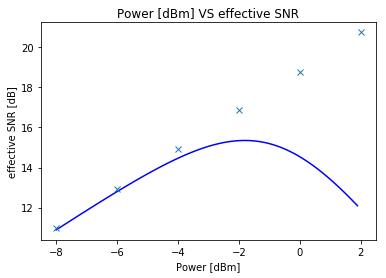

In [14]:
plt.plot(nlinPowerSweep, NLINeffSNR, 'b')
plt.plot(powerSweep, np.array(SSFeffSNR), 'x')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()